# Franchise History Visualization

The WNBA and NBA both contain franchises with rich histories. The following introduces part of the [py_ball](https://github.com/basketballrelativity/py_ball) package through visualizing basketball league history at the franchise level. The code below leverages `matplotlib` for data visualization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from py_ball import league, image

We'll be leveraging the `league` and `image` modules from the `py_ball` package. Also, below is the request header information needed by the NBA stats API. The `User-Agent` key is the only required parameter. More information on the request header requirement can be found [here](https://stackoverflow.com/questions/46781563/how-to-obtain-a-json-response-from-the-stats-nba-com-api).

In [2]:
HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Referer': 'stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

The first function we'll write adds an NBA or WNBA logo image to a `matplotlib` figure. `add_logo` ingests the figure, logo image, and desired location of the logo on the figure. The function shrinks down, rotates, and transposes the image before adding it to the figure in the provided location. Using the logo to label the timeline of a franchise is a more visually appealing alternative to only using a team city or name.

In [3]:
def add_logo(fig, logo, x_frac, y_frac):
    """ This function adds a logo to the provided figure

    Args:

        @param **fig** (matplotlib.figure.Figure): Figure object of franchise
            history barchart

        @param **logo** (PngImageFile): PNG image object of logo corresponding
            to a basketball franchise

        @param **x_frac** (float): Value corresponding to the horizontal position
            at which the image is to be initiated

        @param **y_frac** (float): Value corresponding to the vertical position
            at which the image is to be initiated

    Returns:

        **fig** (matplotlib.figure.Figure): Figure object of franchise
            history barchart with the corresponding logo added
    """

    logo.thumbnail((32, 32), Image.ANTIALIAS)
    logo = logo.rotate(180)
    logo = logo.transpose(Image.FLIP_LEFT_RIGHT)
    img_x, img_y = logo.size[0], logo.size[1]
    x_offset = int((fig.bbox.xmax * x_frac - img_x/2))
    y_offset = int((fig.bbox.ymax * y_frac - img_y/2))
    fig.figimage(logo, origin={'lower'},
                 xo=x_offset, yo=y_offset, zorder=10)

    return fig

`add_franchise_changes` below ingests a figure and location information for years during which a franchise change occurred. This function will provide more context to the history of a franchise in the final visualization.

In [4]:
def add_franchise_changes(fig, years, ind):
    """ This function adds dashed vertical lines when
    the franchise underwent a change (name/city change)

    Args:

        @param **fig** (matplotlib.figure.Figure): Figure object of franchise
            history barchart

        @param **years** (list): List of integers corresponing to years in
            which a franchise change took place

        @param **ind** (float): Value of the vertical location of the bar
            on the barchar

    Returns:

        **fig** (matplotlib.figure.Figure): Figure object of franchise
            history barchart with the franchise changes added
    """

    for year in years:
        plt.plot([year, year], [ind - 0.4, ind + 0.4], 'k--')

    return fig

That does it for helper functions! If you would like a more self-contained version of this code, please see the `franchise_history.py` file in this repository. The code below will walk through the data ingestion and manipulation that occurs in that more compact script. First, the `franchise_history` endpoint of the NBA stats API is called using the `League` class.

In [5]:
league_id = '10' #WNBA
franchises = league.League(headers=HEADERS,
                           endpoint='franchisehistory',
                           league_id=league_id)
franchise_df = pd.DataFrame(franchises.data['FranchiseHistory'])
franchise_df.head(10)

,CONF_TITLES,DIV_TITLES,END_YEAR,GAMES,LEAGUE_ID,LEAGUE_TITLES,LOSSES,PO_APPEARANCES,START_YEAR,TEAM_CITY,TEAM_ID,TEAM_NAME,WINS,WIN_PCT,YEARS
0,3,0,2018,374,10,0,191,8,2008,Atlanta,1611661330,Dream,183,0.489,11
1,1,0,2018,442,10,0,250,4,2006,Chicago,1611661329,Sky,192,0.434,13
2,2,0,2018,672,10,0,312,11,1999,Connecticut,1611661323,Sun,360,0.535,20
3,2,0,2018,544,10,0,244,10,2003,Connecticut,1611661323,Sun,300,0.551,16
4,0,0,2002,128,10,0,68,1,1999,Orlando,1611661323,Miracle,60,0.468,4
5,4,1,2018,702,10,3,391,11,1998,Dallas,1611661321,Wings,311,0.443,21
6,0,0,2018,102,10,0,60,2,2016,Dallas,1611661321,Wings,42,0.411,3
7,0,0,2015,204,10,0,145,1,2010,Tulsa,1611661321,Shock,59,0.289,6
8,4,1,2009,396,10,3,186,8,1998,Detroit,1611661321,Shock,210,0.530,12
9,3,0,2018,640,10,1,324,13,2000,Indiana,1611661325,Fever,316,0.493,19


Investigating the DataFrame above reveals an interesting structure. The same `TEAM_ID` can be seen in multiple rows. For instance, `TEAM_ID = 1611661323` corresponds to the Connecticut Sun franchise. However, this `TEAM_ID` has three rows in the above DataFrame. The table seems to be organized so as to have one row corresponding to the entirety of a franchise's history, in addition to rows for each team in that history. Research confirms that the Orlando Miracle joined the WNBA in 1999 as an expansion team. The franchise then relocated and changed its name to the Connecticut Sun after the 2002 season.

For the purpose of this work, we are primarily concerned with the entirety of a franchise's history, but would also like to respect fundamental changes to a franchise. The cell below selects the DataFrame index of the rows with the maximum number of `YEARS` for each `TEAM_ID`. Also, teams are usually referred to by citing both their location and nickname, so we'll create a `TEAM_FULL` column.

In [6]:
franchise_df['TEAM_FULL'] = franchise_df['TEAM_CITY'] + ' ' + \
                            franchise_df['TEAM_NAME']

franchise_ind = \
    franchise_df.groupby(['TEAM_ID'],
                         sort=False)['YEARS'].transform(max) == \
               franchise_df['YEARS']

Because plotting requires location values to be numeric, we'll need to convert some of our features to a numeric form. Also, we'll overwrite the `YEARS` field in the DataFrame to a more consistent value (specifically, I have found an error in the number of years for the Charlotte Hornets franchise).

In [7]:
franchise_df['YEARS'] = pd.to_numeric(franchise_df['YEARS'])
franchise_df['START_YEAR'] = pd.to_numeric(franchise_df['START_YEAR'])
franchise_df['END_YEAR'] = pd.to_numeric(franchise_df['END_YEAR'])

franchise_df['YEARS'] = franchise_df['END_YEAR'] - \
    franchise_df['START_YEAR']

unique_franchise_df = franchise_df[franchise_ind]
unique_franchise_df = unique_franchise_df.sort_values(by='YEARS',
                                                      ascending=True)

`unique_franchise_df` is a DataFrame that contains only the rows from `franchise_df` for which the number of years for a franchise is a maximum. Onto the visualization! Due to the differing number of teams, the code below adjusts the figure size. `fig.add_axes` is called so as to provide some room to the right of the figure to add team logos.

`axis.barh` adds a horizontal to the `fig` figure object with the width of each bar corresponding to the length in years of a franchise history. `plt.xticks` and `plt.yticks` add year and team labels, respectively, to provide clarity. Finally, the limits of the horizontal axis are set, along with providing initialization values for the placement of team logos.

In [8]:
if league_id == '10':
    fig = plt.figure(figsize=(6, 9))
elif league_id == '00':
    fig = plt.figure(figsize=(6, 12))

axis = fig.add_axes([0., 0., 0.8, 1., ])

axis.barh(bottom=range(0, len(unique_franchise_df)),
          width=unique_franchise_df['YEARS'],
          left=unique_franchise_df['START_YEAR'], height=0.5,
          color='grey')

start_year = min(unique_franchise_df['START_YEAR'])
end_year = max(unique_franchise_df['END_YEAR'])

plt.xticks(range(start_year,
                 end_year + 1,
                 int(round((end_year - start_year)/10.0) + 1)),
           rotation=30)

plt.yticks(range(0, len(unique_franchise_df)),
           unique_franchise_df['TEAM_FULL'],
           rotation=30)

# Logo additions
if league_id == '10':
    horiz_frac = 1
    vertical_frac = 0.12
    increment = 0.08
    league_str = 'WNBA'
    axis.set_xlim(start_year,
                  end_year+4)
elif league_id == '00':
    horiz_frac = 1
    vertical_frac = 0.09
    increment = 0.031
    league_str = 'NBA'
    axis.set_xlim(start_year,
                  end_year+18)

The for-loop below loops through each `TEAM_ID` in `unique_franchise_df` DataFrame, uses the `Logo` class in `py_ball` to get a PNG logo image, and extracts franchise changes from the original `franchise_df` for each franchise. `add_logo` and `add_franchise_changes` are called to add the corresponding information to the `fig` object. After the for-loop concludes, the final figure is shown.

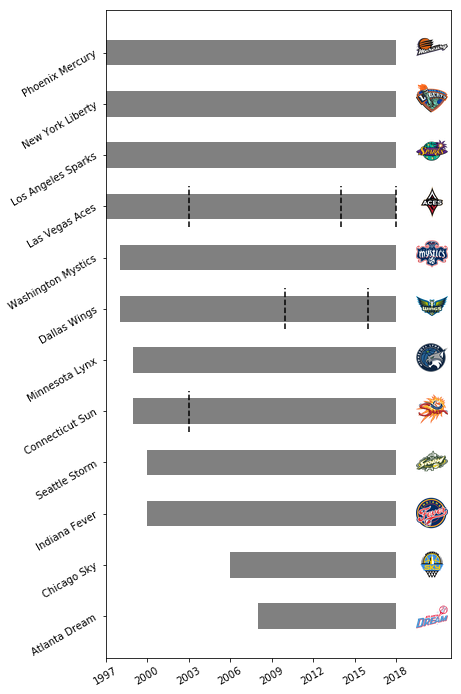

In [9]:
ind = 0
for team_id in unique_franchise_df['TEAM_ID']:
    test_logo = image.Logo(league=league_str,
                           team_id=str(team_id)).image
    fig = add_logo(fig, test_logo, horiz_frac, vertical_frac)
    years_df = \
        franchise_df[franchise_df['TEAM_ID'] == \
                     team_id].sort_values(by='START_YEAR',
                                          ascending=False)
    years = sorted(list(set(years_df['START_YEAR'])))
    fig = add_franchise_changes(fig, years[1:], ind)
    vertical_frac += increment
    ind += 1

plt.show()

The visualization above communicates tremendous information about the history of the WNBA, including:
   - The WNBA has four surviving franchises from its inaugural 1997 season, the Phoenix Mercury, New York Liberty, Los Angeles Sparks, and Las Vegas Aces franchises (the Las Vegas Aces were then the Utah Starzz).
   - The league saw great growth in its early years, adding two lasting franchises in each of the three subsequent seasons.
   - The Las Vegas Aces franchise has gone through the most change. They began as the Utah Starzz, then moved to San Antonio to become the Silver Stars. In 2014, the franchise shortened its nickname to Stars before moving to Las Vegas prior to the 2018 season.
   - All active franchises have been in the league for at least 10 seasons.

## Exploration
- Rerun the notebook after changing the `league_id` variable to '00' to visualize franchise history in the NBA. What information can you glean from the NBA bar chart?
- What other interesting visualizations can you generate from the `franchise_history` endpoint?
- This notebook added team logos and franchise changes to include more context in the visualization. What other information could be added to the bar chart visualization to add greater meaning?